In [1]:
import numpy as np
import scipy

class quaternion(np.ndarray):
  @classmethod
  def fromrotation(cls,phi,vector):
    vector=np.array(vector,copy=False)
    norm=np.linalg.norm(vector)
    if phi==None:
        phi=norm
    cs=np.exp(0.5j*phi)
    return cls(cs.real,*(cs.imag*vector.reshape((3,))/norm))
      
  @classmethod
  def from_rotation_vector(cls,rot):
    return cls.fromrotation(None,rot) 
      
  @classmethod
  def from_vector(cls,vector,normalize=False):
    if normalize:
        norm=np.linalg.norm(vector)
        return cls(0.0,*(np.array(vector,copy=False)/norm)) 
    else:
        return cls(0.0,*np.array(vector,copy=False)) 
    
  def __new__(cls,w=0.0,i=0.0,j=0.0,k=0.0):
      return super().__new__(cls,shape=(2,2),dtype=complex)
      
  def __init__(self,w=1.0,i=0.0,j=0.0,k=0.0):
    wi=w+1.0j*i
    jk=j+1.0j*k
    super().__init__()
    self[:,:]=[[wi,jk],[-jk.conjugate(),wi.conjugate()]]
      
  def __repr__(self):
      wi,jk=self[0]
      w,i,j,k=wi.real,wi.imag,jk.real,jk.imag
      return f'{self.__class__.__name__}({w=}, {i=}, {j=}, {k=})'
  @property
  def H(self):  return super().conjugate().T
  @property
  def w(self):  return self[0,0].real
  @property
  def i(self):  return self[0,0].imag
  @property
  def j(self):  return self[0,1].real
  @property
  def k(self):  return self[0,1].imag
  @property
  def v(self):  return [self.i,self.j,self.k]
  @property
  def real(self):return self.w
  @property
  def imag(self):return np.linalg.norm(self.v)
  @property
  def inv(self):return self.H/(self@self.H).w
  def conjugate(self):
      return self.H
  def __pow__(self,t):
      q=quaternion()
      q[:,:]=scipy.linalg.fractional_matrix_power(self,t)
      return q

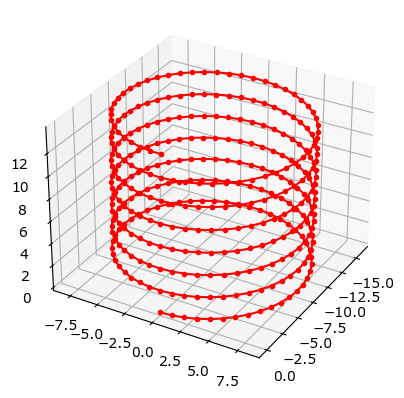

In [28]:
#use quaternions to plot a helix by repeatedly rotating a line segment
from matplotlib import pyplot as plt 
deg=np.pi/180.0
fig=plt.figure()
ax=fig.add_subplot(projection='3d')
def helix(slope,nseg,lseg,maxloops):
    cos_slope,sin_slope=(1-slope**2)**0.5,slope
    dp=quaternion(0,0,cos_slope,sin_slope)*lseg
    qr=quaternion.fromrotation(360/nseg*deg,[0,sin_slope,cos_slope]) # rotate by an angle around a vector
    qr2=qr**0.5 # 1/2 the rotation
    p=quaternion(0)
    dp=qr2@dp@qr2.H #1/2 angle for first segment
    for _ in range(maxloops):
      yield p.v
      p+=dp
      dp=qr@dp@qr.H # rotate by qr for each step
ax.plot3D(*(np.array(list(helix(slope=1/50,nseg=50,lseg=1.0,maxloops=351))).T),'r.-')
limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
ax.set_box_aspect(np.ptp(limits, axis = 1))
ax.view_init(elev=30, azim=30, roll=0)